**Introducción a la programación en paralelo en placas gráficas (GPUs) en Google Colab**

El objetivo de esta notebook es mostrar algunos ejemplos básicos de programación en paralelo utilizando tarjetas graficas (las de los videojuegos), también llamadas *Graphic Processing Units* (GPUs). 

Programaremos una función (kernel) muy básica en **CUDA/C**, en **Python paralelo (Cupy)** y en **thrust (análogo a las librerias stdl de C++ pero en paralelo)**.


**IMPORTANTE**: para correr en GPU en google colab hay que configurar:

Entorno de ejecución -> cambiar tipo de entorno de ejecución

o si lo tienen en inglés:

Runtime-> Change Runtime Type -> GPU. 

Para ejecutar cada linea de código hacer Shift-Enter o Ctrl-Enter o apretar el botón de play.

**Uno de los compiladores de CUDA/C se llama nvcc. Para ver que versión estamos usando en la nube hacemos:**

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


**Para ver que placa o GPU nos tocó en la nube hacer:**

In [2]:
!nvidia-smi

Mon Sep 19 22:33:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Para ver que CPU nos tocó:**

In [3]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes

**Como vamos a programar y correr en CUDA C/C++ , vamos a necesitar instalar el siguiente plugin:**

In [4]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-egfz_gi9
  Running command git clone -q https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-egfz_gi9
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4306 sha256=66a0e170be6f1ecb6b916017ec89cb2ebe81ec50e002751622f09f4c5ed7e5a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-n_6pyfnq/wheels/ca/33/8d/3c86eb85e97d2b6169d95c6e8f2c297fdec60db6e84cb56f5e
Successfully built NVCCPlugin


**y luego cargarlo:**

In [5]:
%load_ext nvcc_plugin


created output directory at /content/src
Out bin /content/result.out


**Listo!, ahora podemos correr codigo CUDA C/C++ en la Jupyter notebook.**

Para terminar, es conveniente montar nuestro google drive, asi podemos acceder a nuestros archivos, que pueden ser headers, etc. Nos va a pedir un permiso y un codigo.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Un ejemplo: función SAXPY
a*x+y 

donde **a es un número** , **x e y son vectores**.

# El plan es implementarla en diferentes lenguajes y comparar tiempos:
1 y 2) En serie con una función de C vs. un kernel en CUDA/C

3) Con la Librería Thrust

4) Con Numpy

3) Con CuPy

# Con una función en C vs. un kernel de CUDA/C

In [8]:
%%cu

#include <sys/time.h>
#include <cstdio>

__global__ void saxpy_cuda(int n, float a, float *x, float *y){
     int t_id = threadIdx.x + blockDim.x * blockIdx.x;
     int stride = blockDim.x * gridDim.x;
     for (int i = t_id; i < n; i += stride)
     {
          y[i] = a * x[i] + y[i];
     }
}
 
void saxpy_cpu(int n, float a, float *x, float *y)
{
	for (int i = 0; i < n; ++i)
		y[i] = a * x[i] + y[i];
}

int main(){
  int n = 1UL << 25;

  float *x, *y, alpha=2.0;
  cudaMalloc(&x, n * sizeof(float));
  cudaMalloc(&y, n * sizeof(float));

  float *xcpu, *ycpu;
  xcpu=(float *)malloc(n * sizeof(float));
  ycpu=(float *)malloc(n * sizeof(float));

  // GPU
  struct timeval t1, t2;
  gettimeofday(&t1, 0);

  saxpy_cuda<<<32, 1024>>>(n, alpha, x, y);
  cudaDeviceSynchronize();
  
  cudaThreadSynchronize();
  gettimeofday(&t2, 0);

  double time = (1000000.0*(t2.tv_sec-t1.tv_sec) + t2.tv_usec-t1.tv_usec)/1000.0;
  printf("Tiempo GPU de saxpy sobre %ld elementos:  %3.1f ms \n", n, time);

  // CPU
  gettimeofday(&t1, 0);

  saxpy_cpu(n, alpha, xcpu, ycpu);
  
  gettimeofday(&t2, 0);

  double timecpu = (1000000.0*(t2.tv_sec-t1.tv_sec) + t2.tv_usec-t1.tv_usec)/1000.0;
  printf("Tiempo CPU de saxpy sobre %ld elementos:  %3.1f ms \n", n, timecpu);

  
  cudaFree(x);
  cudaFree(y);
  free(xcpu);
  free(ycpu);

}

Tiempo GPU de saxpy sobre 33554432 elementos:  2.0 ms 
Tiempo CPU de saxpy sobre 33554432 elementos:  233.9 ms 



# Con la librería Thrust

In [9]:
%%cu
//el símbolo indica que voy a compilar y correr el codigo cuda a continuacion. El símbolo %cu solo compila
//librerias de thrust para hacer un vector en la GPU y una transformación (por ejemplo una suma etc.)
#include <thrust/device_vector.h>
#include <thrust/transform.h>
#include <stdio.h>

#include <sys/time.h>


//los placeholders son para las convenciones de notación _1 y _2 de abajo

using namespace thrust::placeholders;

int main()
{
  int N=1UL << 25;
  int a=2;
  thrust::device_vector<float> x(N),y(N);
  //for(int i=0;i<N;i++){z[i]=rand();};
  thrust::fill(x.begin(),x.end(),1.0);
  thrust::fill(y.begin(),y.end(),1.0);

  struct timeval t1, t2;
  gettimeofday(&t1, 0);

  thrust::transform(x.begin(), x.end(), y.begin(), y.begin(),
  a*_1 + _2
  );

  cudaThreadSynchronize();
  gettimeofday(&t2, 0);

  double time = (1000000.0*(t2.tv_sec-t1.tv_sec) + t2.tv_usec-t1.tv_usec)/1000.0;

  printf("Time to generate saxpy thrust sobre %ld elementos:  %3.1f ms \n", N, time);

}



Time to generate saxpy thrust sobre 33554432 elementos:  1.6 ms 



#Con Python en serie, Numpy.


In [11]:
import numpy as np
import time

N=2**25
x = np.arange(N, dtype=np.float32)
y = np.arange(N, dtype=np.float32)
a = 2
start = time.time()
a*x+y
end = time.time()

print("Time to generate saxpy numpy sobre",N,"elementos:",(end - start)*1000,"ms")

Time to generate saxpy numpy sobre 33554432 elementos: 59.92293357849121 ms


#Con Python en paralelo, Cupy. 

In [13]:
import numpy as np
import cupy as cp
import time

a=2

N=2**25
x_gpu = cp.arange(N, dtype=np.float32)
y_gpu = cp.arange(N, dtype=np.float32)

start = time.time()
a*x_gpu+y_gpu
end = time.time()

print("Time to generate saxpy CuPy sobre",N,"elementos:",(end - start)*1000,"ms")

Time to generate saxpy CuPy sobre 33554432 elementos: 0.835418701171875 ms


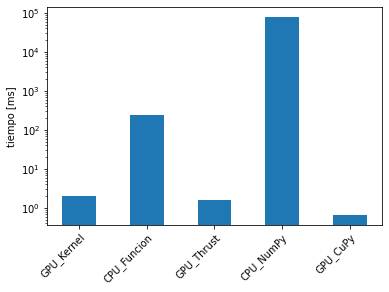

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

N = 5
##completar los tiempos aqui... en orden de aparicion
tiempos = (2,236.8,1.6,77497,0.66)
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
ax.set_xticklabels(('','GPU_Kernel','CPU_Funcion','GPU_Thrust','CPU_NumPy','GPU_CuPy'))
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('tiempo [ms]')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

p1 = ax.bar(ind, tiempos, width)
plt.show()